# Coresets with DPPs

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib widget
%matplotlib inline
%load_ext autoreload 
%autoreload 2
# some highlight keywords by VSCode: TODO, FIXME, BUG, XXX, HACK, NOTE 

## Inspection

### Data generation

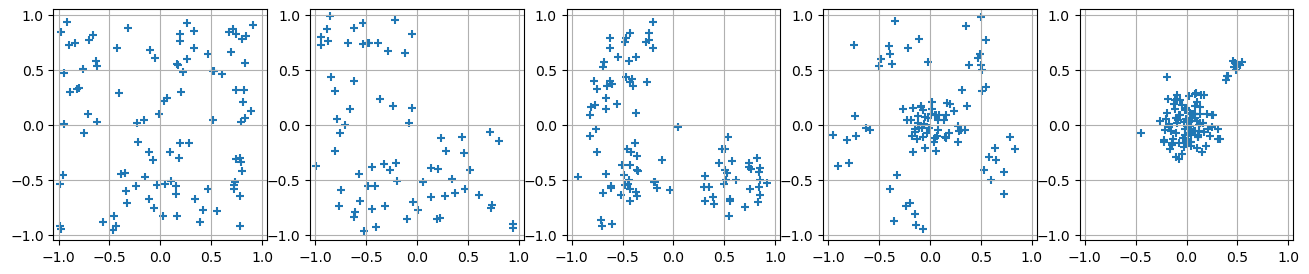

In [3]:
from utils import get_hypercube_data, get_corner_data, get_circle_data

# generate data
desired_n, d, k = 100, 2, 3
X_uniform = get_hypercube_data(desired_n, d, border=.99)
X_subcube = get_hypercube_data(desired_n, d, border=.99, remove_subcube=True)
X_cluster = get_corner_data(desired_n, d, k, border=.99)
X1 = get_circle_data(desired_n/2, d, 5, radius=.8, variance=1/50, border=.99)
X2 = get_circle_data(desired_n/2, d, 1, radius=0, variance=1/50, border=.99)
X_subbubbles = np.concatenate((X1, X2))
X1 = get_circle_data(10, d, 1, radius=.7, variance=1/300, border=.99)
X2 = get_circle_data(desired_n, d, 1, radius=0, variance=1/50, border=.99)
X_outlier = np.concatenate((X1, X2))

# plot
xylim = 1.05
Xs = [X_uniform, X_subcube, X_cluster, X_subbubbles, X_outlier]
plt.figure(figsize=(16,3))
for i_plot, X_plot in enumerate(Xs):
    plt.subplot(1,len(Xs),i_plot+1), plt.grid(), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
    plt.scatter(X_plot[:,0], X_plot[:,1], marker="+");

### Sensitivity

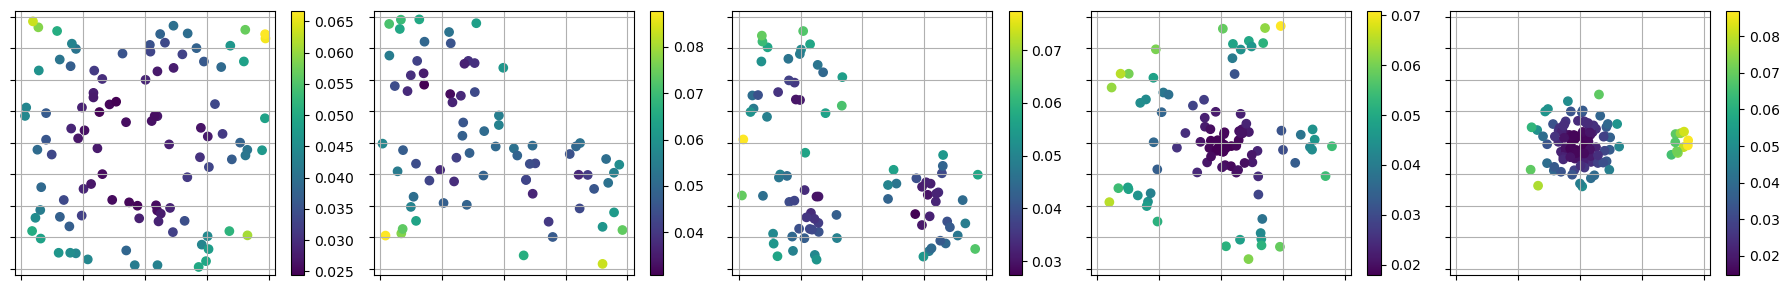

In [3]:
from utils import get_true_sensit

# compute and plot sensitivity
plt.figure(figsize=(18,3))
for i_plot, X_plot in enumerate(Xs):
    sensit = get_true_sensit(X_plot, k)
    plt.subplot(1,len(Xs),i_plot+1), plt.grid(), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
    plt.scatter(X_plot[:,0], X_plot[:,1], c=sensit), plt.colorbar();
    plt.gca().set_xticklabels([]), plt.gca().set_yticklabels([])
    plt.tight_layout()

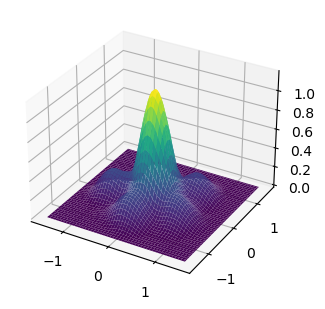

In [4]:
from sklearn.neighbors import KernelDensity
from interfaces import plot3d_func

# compute and plot KDE
kde = KernelDensity(kernel="epanechnikov", bandwidth="scott").fit(X_subbubbles)
gamma_tilde_pdf = lambda X: np.exp(kde.score_samples(X))
plt.figure(figsize=(8,4))
ax = plt.subplot(121, projection="3d")
plot3d_func(ax, gamma_tilde_pdf, 100)

### Gaussian k-DPP weights check

empirically yields m=5.000, which should be close to m=5


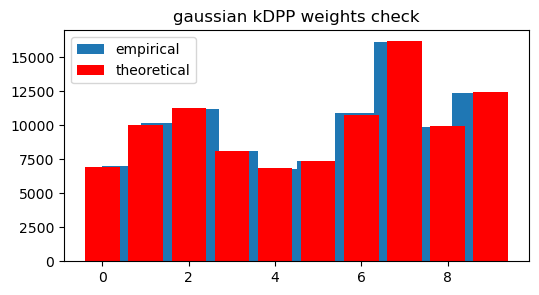

In [5]:
from samplers import gaussian_kernel, get_kDPP_weights, draw_gaussian_kDPP
 
d, n, m, k = 2, 10, 5, 3
X = get_hypercube_data(n, d, border=.99)
n_samples = 20000
bandwidth = 1

likelihood = gaussian_kernel(X, bandwidth)
weights = get_kDPP_weights(likelihood, m)
samples, _ = draw_gaussian_kDPP(X, m, n_samples, bandwidth)
samples = samples.flatten()
print(f"empirically yields m={(1/(n*weights)).sum():.3f}, which should be close to {m=}")
plt.figure(figsize=(6,3))
plt.hist(samples, density=False, label="empirical")
plt.bar(np.arange(len(X)), n_samples/(n*weights), color='r', label="theoretical")
plt.title("gaussian kDPP weights check"), plt.legend();

### Sampling example

obtained n=294


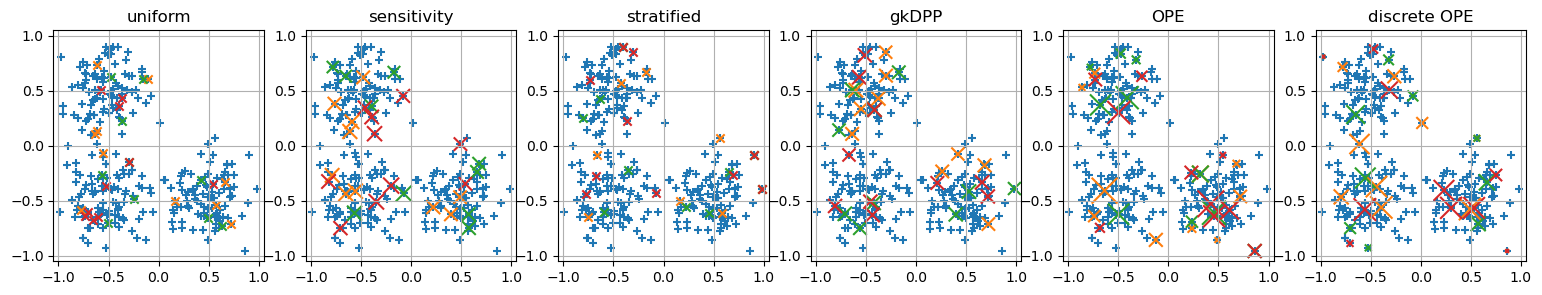

In [3]:
from samplers import draw_uniform, draw_sensitivity, draw_stratified, draw_gaussian_kDPP, draw_OPE, draw_discrete_OPE

# generate data
d, desired_n, m, k = 2, 300, 10, 1
n_samples = 3
# X = get_hypercube_data(desired_n, d, border=.99, remove_subcube=False)
X = get_corner_data(desired_n, d, 3, border=.99)
# X = get_circle_data(desired_n, d, 2, radius=.7, variance=1/50, border=.99)
# X1 = get_circle_data(desired_n/2, d, 3, radius=.8, variance=1/50, border=.99)
# X2 = get_circle_data(desired_n/2, d, 1, radius=0, variance=1/50, border=.99)
# X1 = get_circle_data(10, d, 1, radius=.8, variance=1/300, border=.99)
# X2 = get_circle_data(desired_n, d, 1, radius=0, variance=1/50, border=.99)
# X = np.concatenate((X1, X2))
n = len(X)
print(f"obtained {n=}")

# sample
uniform_samples = draw_uniform(len(X), m, n_samples)
X_uniform = X[uniform_samples]
sensit_samples, sensit_weights = draw_sensitivity(X, m, n_samples, k, .1)
X_sensit = X[sensit_samples]
stratified_samples = draw_stratified(X, m, n_samples)
X_stratified = X[stratified_samples]
gkDPP_samples, gkDPP_weights = draw_gaussian_kDPP(X, m, n_samples, bandwidth=.1)
X_gkDPP = X[gkDPP_samples]
OPE_samples, OPE_weights = draw_OPE(X, m, n_samples, ab_coeff=0, prop_uniform=.1)
X_OPE = X[OPE_samples]
dOPE_samples, dOPE_weights = draw_discrete_OPE(X, m, n_samples)
X_dOPE = X[dOPE_samples]

# plot
titles = ["uniform","sensitivity","stratified","gkDPP","OPE","discrete OPE"]
weights = [None, sensit_weights, None, gkDPP_weights, OPE_weights, dOPE_weights]
plt.figure(figsize=(19,3))
for k, X_samples in enumerate([X_uniform, X_sensit, X_stratified, X_gkDPP, X_OPE, X_dOPE]):
    xylim = 1.05
    plt.subplot(1,len(titles),k+1), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
    plt.scatter(X[:,0], X[:,1], marker='+')
    for i_sample in range(n_samples):
        weight = None
        if weights[k] is not None: weight= 100*m*weights[k][i_sample]
        plt.scatter(X_samples[i_sample,:,0], X_samples[i_sample,:,1], marker="x", s=weight)
    plt.title(titles[k]), plt.grid()
    # plt.gca().set_xticklabels([]), plt.gca().set_yticklabels([])

## Statistics

### Variance and relative error rate

In [2]:
from utils import get_hypercube_data, get_corner_data, get_circle_data
from samplers import draw_uniform, draw_sensitivity, draw_stratified, draw_gaussian_kDPP, draw_OPE, draw_discrete_OPE
from utils import loss, relative_error
from interfaces import save_variables_interface
from sklearn.neighbors import KernelDensity

# data parameters
d, desired_n, k = 2, 512, 1    # 2, 1024, 3
# draw data
X = get_hypercube_data(desired_n, d, border=.99)
# X = get_corner_data(desired_n, d, 3, variance=1/50, border=.99)
# X1 = get_circle_data(desired_n/5, d, 2, radius=.7, variance=1/50, border=.99)
# X1 = get_circle_data(desired_n, d, 3, radius=.8, variance=1/50, border=.99)
# X2 = get_circle_data(desired_n/2, d, 1, radius=0, variance=1/50, border=.99)
# X1 = get_circle_data(desired_n/5, d, 1, radius=.8, variance=1/300, border=.99)
# X2 = get_circle_data(4*desired_n/5, d, 1, radius=0, variance=1/50, border=.99)
# X1 = get_circle_data(10, d, 1, radius=.8, variance=1/300, border=.99)
# X2 = get_circle_data(desired_n, d, 1, radius=0, variance=1/50, border=.99)
# X = np.concatenate((X1, X2))
n = len(X)
print(f"obtained {n=}")
# Xs = [get_hypercube_data(desired_n, d, border=.99) for _ in range(n_datas)]
# for i_data, X in enumerate(Xs):
# for i_data in range(len(n_datas)):
#     print(f"draw data {i_data+1}/{n_datas}")

# repetitions parameters
n_queries, n_rep = 100, 100 # 3, 50, 500
ms = np.arange(3,14, dtype=int)**2 # (1,14)
print(f"m list={ms}")
bandwidths = [.01, .03, .05, .1, .3]
# bandwidths = [.003, .01, .03, .1, .3]
prop_uniforms = np.linspace(0,.94,11)

# init queries
queries = X[np.random.choice(n, (n_queries,k), replace=False)]
# queries = np.zeros((1,1,X.shape[-1]))

# init OPE sampler by pre-computing KDE on data
kde = KernelDensity(kernel="epanechnikov", bandwidth="scott").fit(X)
kde_distr = np.exp(kde.score_samples(X))

SE_means, SE_stds, relerrs = [], [], []
for m in ms:
    print(f"{m=}")
    # sample
    samples_weights_list = []

    samples_weights_list.append( draw_uniform(X, m, n_rep) )
    # samples_weights_list.append( draw_sensitivity(X, m, n_rep, k, delta=.1) )
    # samples_weights_list.append( draw_gaussian_kDPP(X, m, n_rep, bandwidth=.1) )
    # samples_weights_list.append( draw_OPE(X, m, n_rep, gamma_X=kde_distr, prop_uniform=0) )
    # samples_weights_list.append( draw_discrete_OPE(X, m, n_rep) )
    # samples_weights_list.append( draw_stratified(X, m, n_rep) )
    
    # for bandwidth in bandwidths:
    #     samples_weights_list.append( draw_gaussian_kDPP(X, m, n_rep, bandwidth=bandwidth) )

    for prop_uniform in prop_uniforms:
        samples_weights_list.append( draw_OPE(X, m, n_rep, gamma_X=kde_distr, prop_uniform=prop_uniform) )

    # compute metrics for all samplers
    loss_samples = []
    for samples, weights in samples_weights_list:

        for query in queries:
            # evaluate the population loss and the sample loss
            loss_X = loss(X, query) 
            loss_samples = loss(X, query, samples, weights)

            # compute metrics
            SEs = (loss_samples - loss_X)**2
            SE_means.append(SEs.mean(-1))
            SE_stds.append(SEs.std(-1))
            relerrs.append(relative_error(loss_samples, loss_X))

# just draw from OPE to show in scatter plot
OPE_samples, OPE_weights = draw_OPE(X, m, n_rep, gamma_X=kde_distr, prop_uniform=0)
# aggregate metrics
n_ms, n_samplers = len(ms), len(samples_weights_list)
relerrs_sup = np.reshape(relerrs, (n_ms, n_samplers, n_queries, n_rep)).max(2) # max on queries
SE_means, SE_stds = np.reshape(SE_means, (n_ms, n_samplers, n_queries)), np.reshape(SE_stds, (n_ms, n_samplers, n_queries))
SE_means_argmax = SE_means.argmax(2) # argmax on queries
arr1, arr2 = np.ogrid[:n_ms,:n_samplers]
SE_means_sup = SE_means[arr1, arr2, SE_means_argmax]
SE_stds_sup = SE_stds[arr1, arr2, SE_means_argmax]

save_variables_interface("relerrs_sup, SE_means_sup, SE_stds_sup", 
                       output_name=f"uniform_n{n}_m{m}_{k}means{n_queries}", save_on_call=True)

obtained n=512
m list=[  9  16  25  36  49  64  81 100 121 144 169]
m=9
m=16
m=25
m=36
m=49
m=64
m=81
m=100
m=121
m=144
m=169
Saved variables in ./npys/ folder. To load, type:
```
uniform_n512_m169_1means100 = np.load("./npys/uniform_n512_m169_1means100.npy", allow_pickle=True).item()
relerrs_sup, SE_means_sup, SE_stds_sup, = uniform_n512_m169_1means100.values()
```


interactive(children=(Text(value='relerrs_sup, SE_means_sup, SE_stds_sup', description='variable_names'), Text…

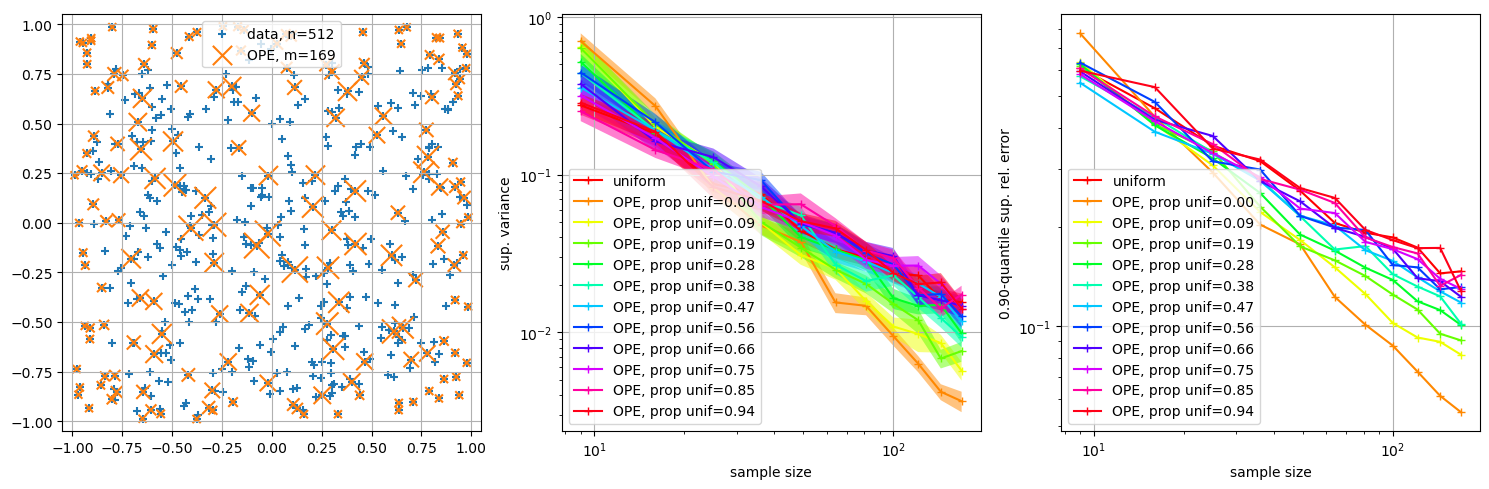

interactive(children=(FloatSlider(value=15.0, description='fig_width', max=20.0, min=4.0, step=0.2), FloatSlid…

interactive(children=(Text(value='./figs/', description='fig_directory'), Text(value='FIG', description='fig_n…

In [6]:
def my_plot():
    n_stds = 1*n_rep**(-.5) # number of standard deviations to plot
    xylim = 1.05

    plt.subplot(131), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
    plt.scatter(X[:,0], X[:,1], marker="+", label=f"data, {n=}")
    X_samples, X_weights = X[OPE_samples[0]], 100*m*OPE_weights[0]
    plt.scatter(X_samples[:,0],X_samples[:,1], marker="x", label=f"OPE, {m=}", s=X_weights)
    plt.legend(), plt.grid()

    plt.subplot(132)
    legends = ["uniform","sensitivity","gaussian kDPP","OPE","discrete OPE","stratified"]
    # legends = ["uniform","sensitivity","gaussian kDPP","OPE","discrete OPE"]
    # legends = ["uniform","sensitivity","OPE","discrete OPE"]
    # legends = ["uniform"]+["gkDPP, h="+str(bandwidth) for bandwidth in bandwidths]
    legends = ["uniform"]+[f"OPE, prop unif={prop_uniform:.2f}" for prop_uniform in prop_uniforms]
    colors = ["cyan","blue","darkviolet","red","orange","maroon"]
    # colors = ["cyan","mediumblue","red","orange"]
    cmap = plt.get_cmap('hsv')
    colors = cmap(np.linspace(0,1,len(legends)))
    plt.gca().set_prop_cycle(color=colors)
    plt.plot(ms, SE_means_sup, label=legends, marker="+")
    for k, legend in enumerate(legends):
        plt.fill_between(ms, SE_means_sup[:,k]+n_stds*SE_stds_sup[:,k], SE_means_sup[:,k]-n_stds*SE_stds_sup[:,k], alpha=.5)
    plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel("sup. variance"), 
    plt.legend(), plt.grid(),

    plt.subplot(133)
    delta_quant = .1 # .1, .01
    relerr_quant = np.quantile(relerrs_sup, 1-delta_quant, axis=-1)
    plt.gca().set_prop_cycle(color=colors)
    plt.plot(ms, relerr_quant, label=legends, marker="+")
    plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel(f"{1-delta_quant:.2f}-quantile sup. rel. error")
    plt.legend(), plt.grid(),

from interfaces import save_plots_interface
save_plots_interface(my_plot, fig_size=(15,5), plot_on_call=True)

## Power regression

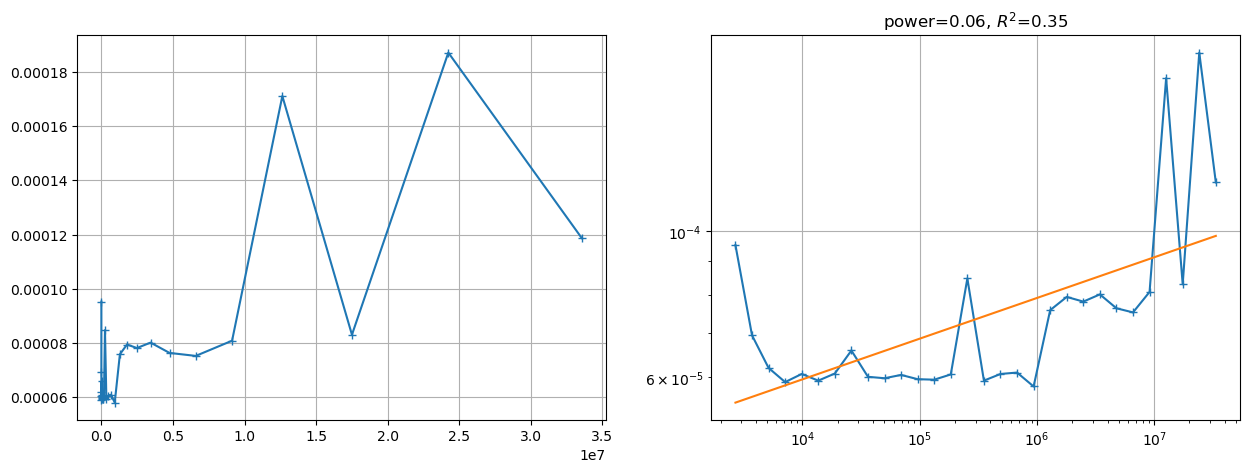

In [27]:
from sklearn.linear_model import LinearRegression

def power_regression(x, y):
    plt.subplot(121)
    plt.plot(x, y, marker="+"), plt.grid()
    logx, logy = np.log(x)[:,None], np.log(y)
    reg = LinearRegression().fit(logx, logy)
    power, factor = reg.coef_, np.exp(reg.intercept_)
    R_squared = reg.score(logx, logy)
    
    plt.subplot(122)
    plt.plot(x, y, marker="+")
    plt.plot(x, np.exp(reg.predict(logx)))
    plt.xscale('log'), plt.yscale('log')
    plt.title(f"power={power[0]:.2f}, $R^2$={R_squared:.2f}"), plt.grid();
    return reg

k_start = 20
plt.figure(figsize=(15,5))
fitted_reg = power_regression(n_list[k_start:], elapsed_times[k_start:])

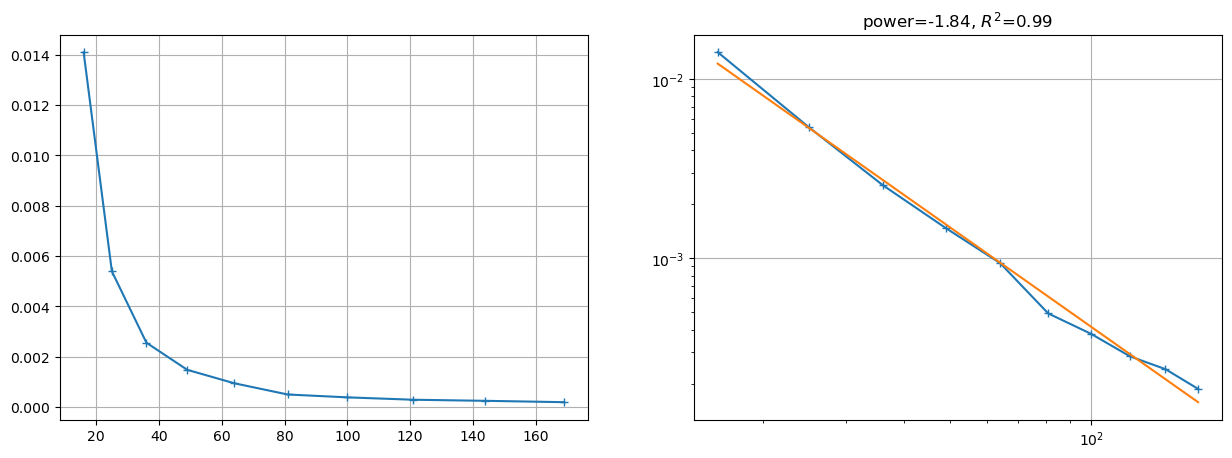

In [44]:
k_start, k_end = 3, None
plt.figure(figsize=(15,5))
fitted_reg = power_regression(ms[k_start:k_end], SE_means[:,2][k_start:k_end])

### Benchmark DPPy sample_exact

In [26]:
from timeit import default_timer as timer
elapsed_times = []
n_list = []
d, n, nb_rep = 2, 2000, 10
ns = np.round(np.logspace(2, 25, num=50, base=2)).astype(int) # 20
# ns = np.arange(1, 30)**4
print(ns)
ab_coeff = 0
ab_coeff_array = np.zeros((d,2)) + ab_coeff
for n in ns:
    print(f"n={n}")
    start_time = timer()
    for rep in range(nb_rep):
        # X = get_hypercube_data(n, d)
        # obtain P which decompose continuous DPP K = PP^T
        # dpp = MultivariateJacobiOPE(m, ab_coeff_array)
        # polynom_X = dpp.eval_multiD_polynomials(X)
        # eig_vals, eig_vecs, weights = draw_OPE(X, int(m), gamma_X=.25)
        # OPE_samples = get_DPP_samples(eig_vals[:m], eig_vecs[:,:m], n_samples=2)
        # gamma_tilde = stats.gaussian_kde(X.T)
        # gamma_X = gamma_tilde.pdf(X.T)
        truc= np.round(n*np.random.rand(nb_rep))
    n_list.append(n)
    elapsed_times.append(timer() - start_time)

[       4        6        8       11       15       20       28       39
       54       75      104      143      198      275      380      527
      729     1010     1398     1935     2680     3710     5136     7111
     9846    13632    18874    26131    36179    50090    69351    96018
   132939   184057   254831   352820   488487   676320   936380  1296439
  1794947  2485144  3440736  4763774  6595549  9131681 12643011 17504524
 24235395 33554432]
n=4
n=6
n=8
n=11
n=15
n=20
n=28
n=39
n=54
n=75
n=104
n=143
n=198
n=275
n=380
n=527
n=729
n=1010
n=1398
n=1935
n=2680
n=3710
n=5136
n=7111
n=9846
n=13632
n=18874
n=26131
n=36179
n=50090
n=69351
n=96018
n=132939
n=184057
n=254831
n=352820
n=488487
n=676320
n=936380
n=1296439
n=1794947
n=2485144
n=3440736
n=4763774
n=6595549
n=9131681
n=12643011
n=17504524
n=24235395
n=33554432


In [25]:
np.random.choice(n, nb_rep), np.random.rand(n, nb_rep).shape

(array([20451574,  6466630, 30246717, 25200919,  1867114, 11104117,
         2257348, 16958323,  4892921, 30294148]),
 (33554432, 10))